In [1]:
library(ggplot2)
library(ggpubr)
library(corrplot)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
library(dplyr)
library(circlize)
library(ggrepel)
library(ggpubr)
library(ComplexUpset)
library(patchwork)

options(bitmapType = 'cairo')
Sys.setlocale("LC_NUMERIC", "C")

corrplot 0.92 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




[1] "C"

In [ ]:
install.packages

In [2]:
color_tissues <- fread(sprintf('%scolor_tissues.txt', "~/tools/castom_cad_scz/jupyter_notebook/"), h=T, stringsAsFactors=F, data.table = F)

In [3]:
results_dir <- "/scratch/tmp/dolgalev/castom-igex-revision/results/no_gwas/"

In [167]:
load_res <- function(fold, tissue){
    
    df <- read.delim(sprintf('%s/resPrior_regEval_allchr.txt', fold), h = T, stringsAsFactors = F, sep = '\t')
    df$tissue <- tissue
    df$n_regSNPs <- NA
    
    # reg-SNPs per gene, regardless category
    coef <- get(load(sprintf('%s/resPrior_regCoeffSnps_allchr.RData', fold)))
    for(id_chr in 1:length(coef)){
        n_snps <- colSums(coef[[id_chr]]!=0)
        df$n_regSNPs[df$chrom == paste0('chr', id_chr)] <- n_snps
    }
    df$n_regSNPs[is.na(df$dev)] <- NA
    
    return(df)
}

create_cor2 <- function(tissues_name, res, id_z){
  
  cor_res <- diag(rep(1, length(tissues_name)), ncol = length(tissues_name))
  corpval_res <- diag(rep(1, length(tissues_name)),ncol = length(tissues_name))
  percint_res <- diag(rep(1, length(tissues_name)),ncol = length(tissues_name))
  
  for(i in 1:(length(tissues_name)-1)){
    ti <- res[res$tissue  %in%  tissues_name[i],]
    trest <- lapply((i+1):length(tissues_name), function(x) res[res$tissue  %in%  tissues_name[x],])
    gene_int <- lapply(trest, function(x) intersect(ti[,8], x[,8]))
    gene_union <- lapply(trest, function(x) union(ti[,8], x[,8]))
    
    # match
    ti_match <- lapply(gene_int, function(x) ti[match(x, ti[,8]), ])
    trest_match <- mapply(function(x,y) x[match(y, x[,8]), ], x = trest, y = gene_int, SIMPLIFY = F)
    
    percint_res[i, (i+1):length(tissues_name)] <- mapply(function(x,y) length(x)/length(y), x = gene_int, y = gene_union)
    
    tmp <- mapply(function(x,y) cor.test(x[,id_z],y[,id_z], method = 'pearson'), x = ti_match, y = trest_match, SIMPLIFY = F)
    
    cor_res[i, (i+1):length(tissues_name)] <- sapply(tmp, function(x) x$estimate)
    corpval_res[i, (i+1):length(tissues_name)] <- sapply(tmp, function(x) x$p.value)
    
  }
  cor_res <- cor_res + t(cor_res) - diag(diag(cor_res))
  corpval_res <- corpval_res + t(corpval_res) - diag(diag(corpval_res))
  percint_res <- percint_res + t(percint_res) - diag(diag(percint_res))
  
  rownames(cor_res) <- colnames(cor_res) <- rownames(corpval_res) <- colnames(corpval_res) <- tissues_name
  rownames(percint_res) <- colnames(percint_res) <- tissues_name
  
  return(list(cor = cor_res, pval = corpval_res, perc = percint_res))
  
}
                                                         
pl_corr2 <- function (res_cor, tissues_name){
    
    diag(res_cor$cor) <- NA
    col <- colorRampPalette(brewer.pal(9, "Oranges"))(100)
  
    corrplot(res_cor$cor, type = "upper", 
        tl.col = "black", col = c(col), mar = c(1, 1, 3, 6), cl.pos = "n",
        method = "color", tl.srt = 45, cl.align.text = "c", addCoef.col = "black", number.cex = 0.8, tl.pos = "lt",
        na.label = "square", na.label.col = "darkgrey", is.corr = F, col.lim = c(0.995, 1.00), number.digits = 6)
   
    diag(res_cor$perc) <- NA
    col <- colorRampPalette(brewer.pal(9, "Greens"))(100)
    
    corrplot(res_cor$perc, type = "lower", tl.col = "black", 
        col = c(col), method = "color", tl.srt = 45,tl.pos = "n", cl.pos = "n",
        cl.align.text = "c", addCoef.col = "black", na.label = "square",
        na.label.col = "darkgrey", is.corr = F, number.cex = 0.8, col.lim = c(0.9, 1.0), number.digits = 6, add = TRUE)
}
                                                         
plot_R2_dist2 <- function(tissue_tmp, df_gene, df_summary, col_plot, save_file = NULL) {
    
  id <- names(which(table(df_gene$ensembl_gene_id[df_gene$reliable]) == length(unique(df_gene$tissue))))
  df_plot <- df_gene
  df_plot$tissue_name <- df_plot$tissue
  df_plot$tissue_name <- factor(df_plot$tissue_name, 
                                levels = df_summary$complete_name[df_summary$tissue == tissue_tmp])

  df_med_c <- df_plot %>% 
          filter(reliable, ensembl_gene_id %in% id) %>%
          group_by(tissue_name) %>% 
          summarise(med = median(dev_geno), med_test = median(test_dev_geno))
df_med_c
pl_box_R2_c <- ggplot(subset(df_plot, reliable & ensembl_gene_id %in% id), 
                    aes(x = tissue_name, y=dev_geno)) + 
  geom_boxplot(width = 0.5, outlier.size = 0.3, alpha = 0.7, size = 0.3, 
               fill = col_plot$color[col_plot$tissue == tissue_tmp])+ 
  ylab(expression(R^2))+ 
  xlab('')+ theme_bw()+ 
  scale_fill_manual(values = col_plot$color[col_plot$tissue == tissue_tmp])+
  ggtitle(sprintf('Final model\n(%i common genes)', length(id)))+
  geom_line(size = 1, data = df_med_c, mapping = aes(x = tissue_name, y = med, group=1), 
            color = 'grey80')+
  #scale_y_continuous(trans=weird)+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_text(size = 12, angle = 0, hjust = 1),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

df_plot_c <- subset(df_plot, reliable & ensembl_gene_id %in% id)
  
df_plot_cw <- df_plot_c %>% 
  select(ensembl_gene_id, tissue, test_dev_geno) %>% 
  tidyr::pivot_wider(names_from = tissue, values_from = test_dev_geno) %>% 
  na.omit()
  
ttp <- round(t.test(df_plot_cw[[2]], df_plot_cw[[3]], paired = TRUE)$p.value, 3)
  
pl_box_R2_test_c <- ggplot(df_plot_c, 
                    aes(x = tissue_name, y=test_dev_geno)) + 
  geom_boxplot(width = 0.5, outlier.size = 0.3, alpha = 0.7, size = 0.3, 
               fill = col_plot$color[col_plot$tissue == tissue_tmp])+ 
  ylab(expression(R[CV]^2))+ 
  xlab('')+ theme_bw()+ 
  #geom_line(size = 1, data = df_med_c, 
  #          mapping = aes(x = tissue_name, y = med_test, group=1), 
  #          color = 'grey80')+
  #scale_y_continuous(trans=weird)+
  ggtitle('Common genes')+
  scale_y_continuous(limits = c(-0.05, 1))+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  ggpubr::geom_bracket(xmin = 1, xmax = 2, y.position = max(df_plot_c$test_dev_geno) + 0.05, label = sprintf("p==%s", ttp), type = "expression", hjust = 0, vjust = 0.4, angle = 0, label.size = 3, coord.flip = TRUE) +
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 12),
        #axis.text.y=element_blank(),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

    if(!is.null(save_file)){
        ggsave(filename = save_file, plot = tot_pl, width = 8, height = 2)
        
    }

  return(pl_box_R2_test_c)
}

In [24]:
no_axis <- function(plot, which) {
  if (which == "x" | which == "both") {
    plot <- plot + theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
  }
  
  if (which == "y" | which == "both") {
    plot <- plot + theme(axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
  }
  
  return(plot)
}

In [5]:
common_name <- "/scratch/tmp/dolgalev/castom-igex-revision/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/"

folder_train_avo <- vector(mode = "character")
folder_train_aao <- vector(mode = "character")
folder_train_liv <- vector(mode = "character")

folder_sample_avo <- vector(mode = "character")
folder_sample_aao <- vector(mode = "character")
folder_sample_liv <- vector(mode = "character")

name_t_avo <- vector(mode = "character")
name_t_aao <- vector(mode = "character")
name_t_liv <- vector(mode = "character")

for (i in c("", "_nogwas")) {
  folder_train_avo <- c(folder_train_avo, sprintf("%s/Adipose_Visceral_Omentum/200kb/CAD_GWAS_bin5e-2%s", common_name, i))
  folder_train_aao <- c(folder_train_aao, sprintf("%s/Artery_Aorta/200kb/CAD_GWAS_bin5e-2%s", common_name, i))
  folder_train_liv <- c(folder_train_liv, sprintf("%s/Liver/200kb/CAD_GWAS_bin5e-2%s", common_name, i))
  
  folder_sample_avo <- c(folder_sample_avo, sprintf("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/INPUT_DATA/Covariates/%s/covariates_EuropeanSamples.txt", "Adipose_Visceral_Omentum"))
  folder_sample_aao <- c(folder_sample_aao, sprintf("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/INPUT_DATA/Covariates/%s/covariates_EuropeanSamples.txt", "Artery_Aorta"))
  folder_sample_liv <- c(folder_sample_liv, sprintf("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/INPUT_DATA/Covariates/%s/covariates_EuropeanSamples.txt", "Liver"))
  
  name_t_avo <- c(name_t_avo, sprintf("Adipose Visceral Omentum (%s)", ifelse(i == "", "with GWAS prior", "no GWAS prior")))
  name_t_aao <- c(name_t_aao, sprintf("Artery Aorta (%s)", ifelse(i == "", "with GWAS prior", "no GWAS prior")))
  name_t_liv <- c(name_t_liv, sprintf("Liver (%s)", ifelse(i == "", "with GWAS prior", "no GWAS prior")))
}
                                                   
tissues_model_avo <- data.frame(tissue = name_t_avo, folder_sample = folder_sample_avo, folder_train = folder_train_avo)
tissues_model_aao <- data.frame(tissue = name_t_aao, folder_sample = folder_sample_aao, folder_train = folder_train_aao)
tissues_model_liv <- data.frame(tissue = name_t_liv, folder_sample = folder_sample_liv, folder_train = folder_train_liv)

In [6]:
df_gene_avo <- list()
df_gene_aao <- list()
df_gene_liv <- list()

for (i in 1:2) {
  tmp <- load_res(fold = tissues_model_avo$folder_train[i], tissue = tissues_model_avo$tissue[i])
  df_gene_avo[[i]] <- tmp
  
  tmp <- load_res(fold = tissues_model_aao$folder_train[i], tissue = tissues_model_aao$tissue[i])
  df_gene_aao[[i]] <- tmp
  
  tmp <- load_res(fold = tissues_model_liv$folder_train[i], tissue = tissues_model_liv$tissue[i])
  df_gene_liv[[i]] <- tmp
}

col_keep_avo <- names(which(table(unlist(sapply(df_gene_avo, colnames))) == length(df_gene_avo)))
df_gene_avo <- lapply(df_gene_avo, function(x) x[, colnames(x) %in% col_keep_avo])
df_gene_avo <- do.call(rbind, df_gene_avo)
df_gene_avo$reliable <- F
df_gene_avo$reliable[df_gene_avo$test_dev_geno>0 & df_gene_avo$dev_geno>0.01] <- T

col_keep_aao <- names(which(table(unlist(sapply(df_gene_aao, colnames))) == length(df_gene_aao)))
df_gene_aao <- lapply(df_gene_aao, function(x) x[, colnames(x) %in% col_keep_aao])
df_gene_aao <- do.call(rbind, df_gene_aao)
df_gene_aao$reliable <- F
df_gene_aao$reliable[df_gene_aao$test_dev_geno>0 & df_gene_aao$dev_geno>0.01] <- T
             
col_keep_liv <- names(which(table(unlist(sapply(df_gene_liv, colnames))) == length(df_gene_liv)))
df_gene_liv <- lapply(df_gene_liv, function(x) x[, colnames(x) %in% col_keep_liv])
df_gene_liv <- do.call(rbind, df_gene_liv)
df_gene_liv$reliable <- F
df_gene_liv$reliable[df_gene_liv$test_dev_geno>0 & df_gene_liv$dev_geno>0.01] <- T

In [7]:
df_gene_avo = df_gene_avo[df_gene_avo$reliable, ]
df_gene_aao = df_gene_aao[df_gene_aao$reliable, ]
df_gene_liv = df_gene_liv[df_gene_liv$reliable, ]

In [8]:
df_summary_avo <- df_gene_avo %>% 
    group_by(tissue) %>% 
    summarise(n_genes = sum(reliable)) %>% 
    mutate(n_regSNPs = NA, frac_prior = NA, n_samples = NA)
df_summary_avo <- df_summary_avo[match(tissues_model_avo$tissue, df_summary_avo$tissue),]

for(i in 1:nrow(tissues_model_avo)){
    tmp <- read.table(tissues_model_avo$folder_sample[i], h=T, stringsAsFactors = F)
    df_summary_avo$n_samples[i] <- nrow(tmp)
    
}

df_summary_avo <- df_summary_avo %>% rename(complete_name = tissue)
df_summary_avo$tissue <- "Adipose_Visceral_Omentum"
df_summary_avo$percentage <- as.numeric(sapply(df_summary_avo$complete_name, function(x) strsplit(x, split = "[(%)]")[[1]][2]))   
df_summary_avo <- df_summary_avo %>% arrange(tissue, percentage)
rownames(df_summary_avo) <- NULL 
df_summary_avo$percentage <- paste0(df_summary_avo$percentage, "%")                                                         

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [9]:
df_summary_aao <- df_gene_aao %>% 
    group_by(tissue) %>% 
    summarise(n_genes = sum(reliable)) %>% 
    mutate(n_regSNPs = NA, frac_prior = NA, n_samples = NA)
df_summary_aao <- df_summary_aao[match(tissues_model_aao$tissue, df_summary_aao$tissue),]

for(i in 1:nrow(tissues_model_aao)){
    tmp <- read.table(tissues_model_aao$folder_sample[i], h=T, stringsAsFactors = F)
    df_summary_aao$n_samples[i] <- nrow(tmp)
    
}

df_summary_aao <- df_summary_aao %>% rename(complete_name = tissue)
df_summary_aao$tissue <- "Artery_Aorta"
df_summary_aao$percentage <- as.numeric(sapply(df_summary_aao$complete_name, function(x) strsplit(x, split = "[(%)]")[[1]][2]))   
df_summary_aao <- df_summary_aao %>% arrange(tissue, percentage)
rownames(df_summary_aao) <- NULL 
df_summary_aao$percentage <- paste0(df_summary_aao$percentage, "%")                                                         

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [10]:
df_summary_liv <- df_gene_liv %>% 
    group_by(tissue) %>% 
    summarise(n_genes = sum(reliable)) %>% 
    mutate(n_regSNPs = NA, frac_prior = NA, n_samples = NA)
df_summary_liv <- df_summary_liv[match(tissues_model_liv$tissue, df_summary_liv$tissue),]

for(i in 1:nrow(tissues_model_liv)){
    tmp <- read.table(tissues_model_liv$folder_sample[i], h=T, stringsAsFactors = F)
    df_summary_liv$n_samples[i] <- nrow(tmp)
    
}

df_summary_liv <- df_summary_liv %>% rename(complete_name = tissue)
df_summary_liv$tissue <- "Liver"
df_summary_liv$percentage <- as.numeric(sapply(df_summary_liv$complete_name, function(x) strsplit(x, split = "[(%)]")[[1]][2]))   
df_summary_liv <- df_summary_liv %>% arrange(tissue, percentage)
rownames(df_summary_liv) <- NULL 
df_summary_liv$percentage <- paste0(df_summary_liv$percentage, "%")  

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [11]:
col_plot_avo <- color_tissues %>% filter(tissues %in% unique(df_summary_avo$tissue))
col_plot_aao <- color_tissues %>% filter(tissues %in% unique(df_summary_aao$tissue))
col_plot_liv <- color_tissues %>% filter(tissues %in% unique(df_summary_liv$tissue))

In [168]:
avo_R2 <- plot_R2_dist2(tissue_tmp = "Adipose_Visceral_Omentum", df_gene = df_gene_avo, df_summary = df_summary_avo, col_plot = col_plot_avo)
aao_R2 <- plot_R2_dist2(tissue_tmp = "Artery_Aorta", df_gene = df_gene_aao, df_summary = df_summary_aao, col_plot = col_plot_aao)
liv_R2 <- plot_R2_dist2(tissue_tmp = "Liver", df_gene = df_gene_liv, df_summary = df_summary_liv, col_plot = col_plot_liv)

In [171]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
r2_box <- no_axis(avo_R2, "x") / (no_axis(aao_R2, "x") + labs(title = NULL))  / (liv_R2 + labs(title = NULL))

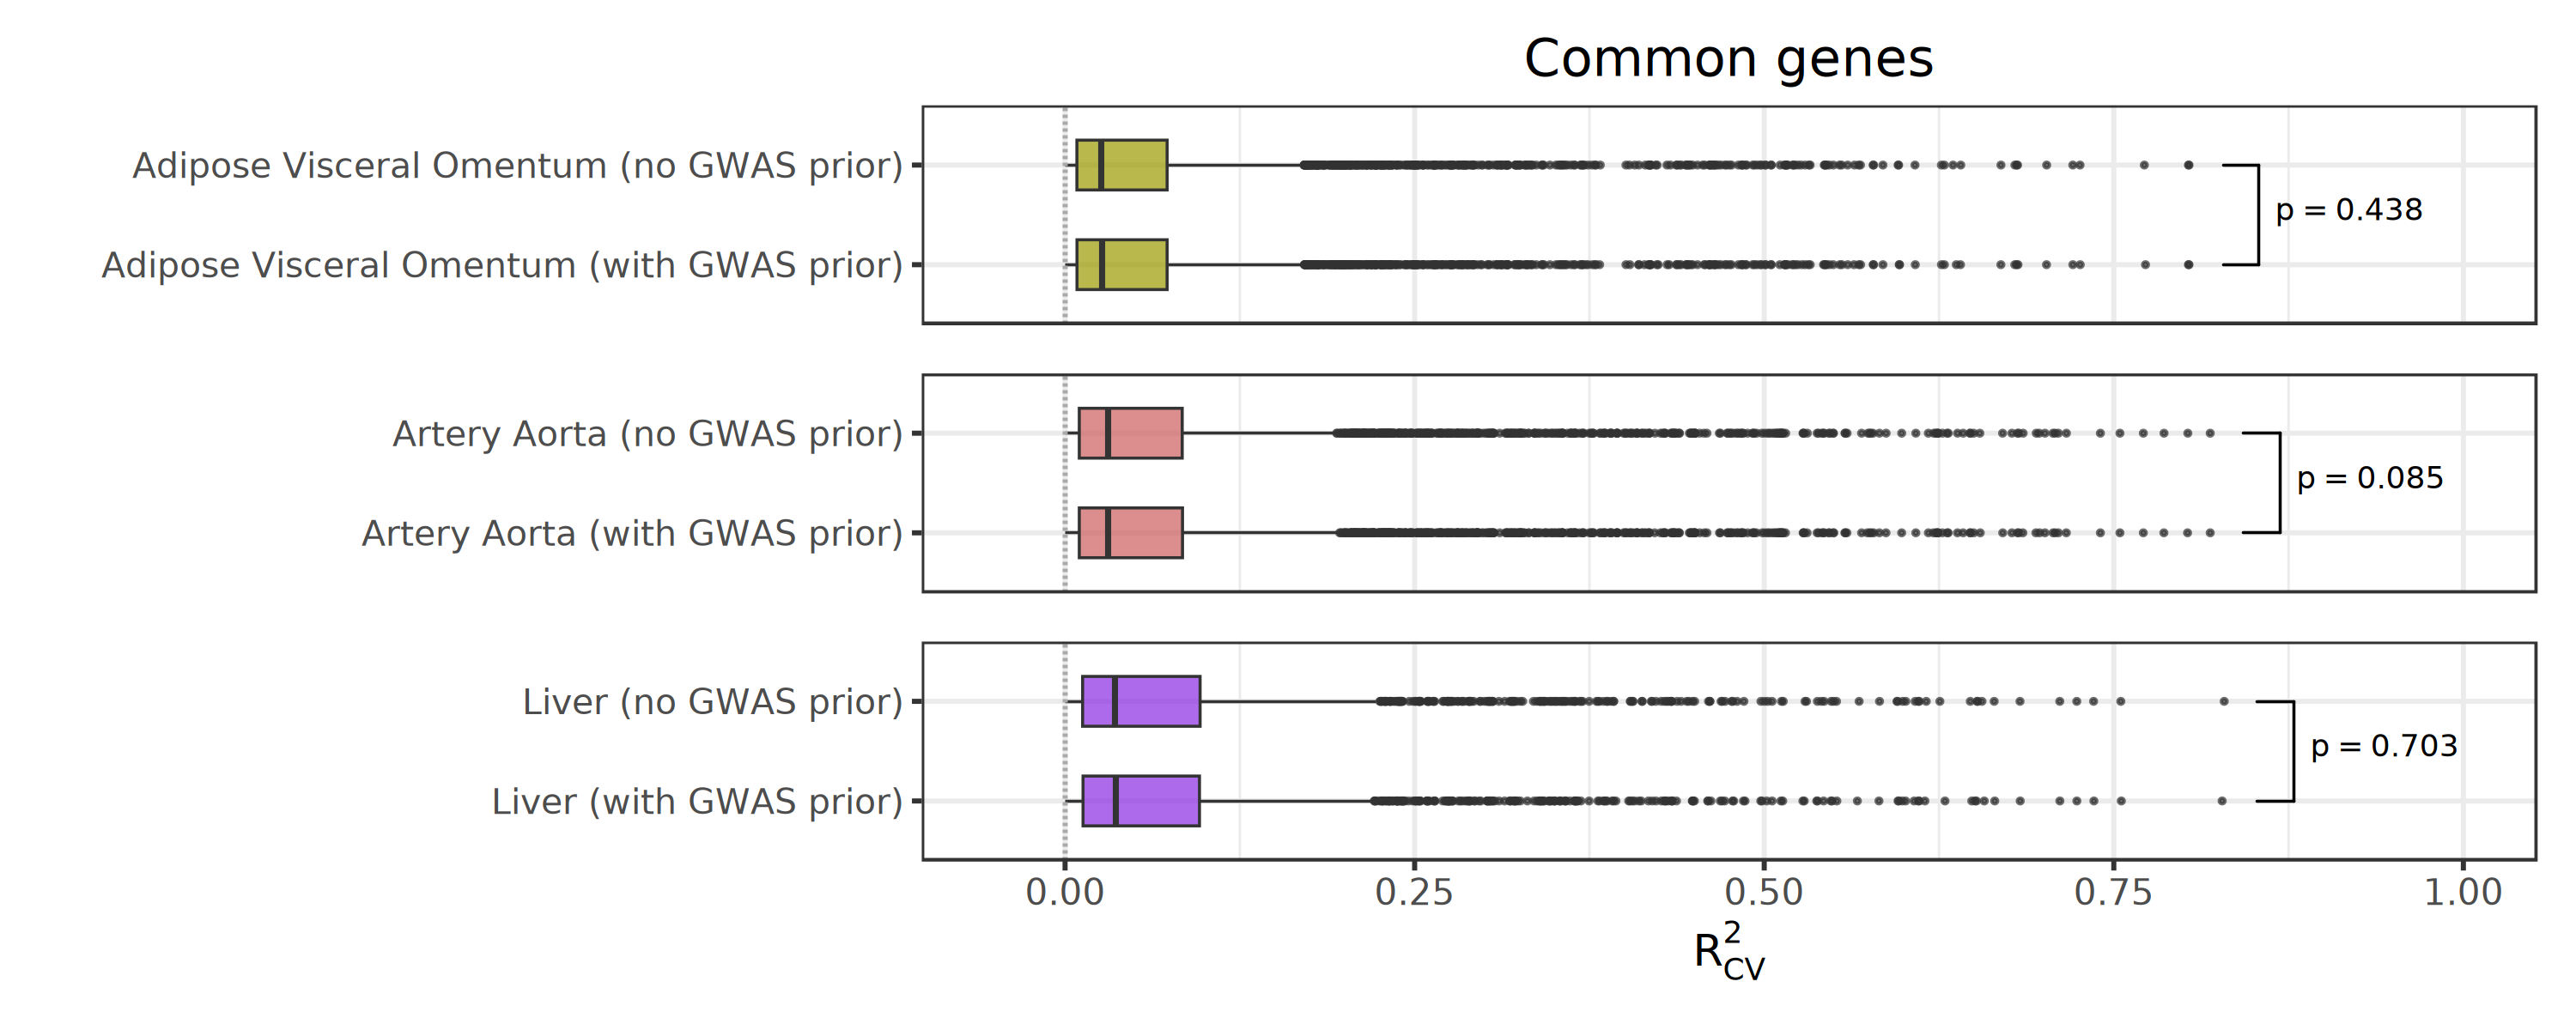

In [172]:
r2_box

In [173]:
ggsave(paste0(results_dir, "nogwas_train_r2_boxplot.pdf"), r2_box, width = 9, height = 4, dpi = 300)

In [174]:
dgavo <- df_gene_avo %>% 
  select(ensembl_gene_id, tissue, test_dev_geno) %>% 
  arrange(ensembl_gene_id, tissue) %>% 
  filter(duplicated(ensembl_gene_id) | duplicated(ensembl_gene_id, fromLast = TRUE)) %>% 
  mutate(tissue = stringr::str_extract(tissue, "(with|no) GWAS", group = 1)) %>% 
  tidyr::pivot_wider(values_from = test_dev_geno, names_from = tissue)

dgaao <- df_gene_aao %>% 
  select(ensembl_gene_id, tissue, test_dev_geno) %>% 
  arrange(ensembl_gene_id, tissue) %>% 
  filter(duplicated(ensembl_gene_id) | duplicated(ensembl_gene_id, fromLast = TRUE)) %>% 
  mutate(tissue = stringr::str_extract(tissue, "(with|no) GWAS", group = 1)) %>% 
  tidyr::pivot_wider(values_from = test_dev_geno, names_from = tissue)

dgliv <- df_gene_liv %>% 
  select(ensembl_gene_id, tissue, test_dev_geno) %>% 
  arrange(ensembl_gene_id, tissue) %>% 
  filter(duplicated(ensembl_gene_id) | duplicated(ensembl_gene_id, fromLast = TRUE)) %>% 
  mutate(tissue = stringr::str_extract(tissue, "(with|no) GWAS", group = 1)) %>% 
  tidyr::pivot_wider(values_from = test_dev_geno, names_from = tissue)

In [187]:
options(repr.plot.height = 3)

dgavop <- ggplot(dgavo, aes(x = with, y = no)) +
  geom_abline(intercept = 0, slope = 1, color = "gray") +
  geom_point(color = col_plot_avo$color[1], alpha = 0.5) +
  ggpubr::stat_cor(r.accuracy = 0.0000001, size = 3) +
  labs(x = expression(R[CV]^2 ~ "(with GWAS prior)"), y = expression(R[CV]^2 ~ "(no GWAS prior)"), title = "Adipose Visceral Omentum") +
  theme_bw() +
  theme(title = element_text(size = 9))

dgaaop <- ggplot(dgaao, aes(x = with, y = no)) +
  geom_abline(intercept = 0, slope = 1, color = "gray") +
  geom_point(color = col_plot_aao$color[1], alpha = 0.5) +
  ggpubr::stat_cor(r.accuracy = 0.0000001, size = 3) +
  labs(x = expression(R[CV]^2 ~ "(with GWAS prior)"), y = expression(R[CV]^2 ~ "(no GWAS prior)"), title = "Artery Aorta") +
  theme_bw() +
  theme(title = element_text(size = 9))

dglivp <- ggplot(dgliv, aes(x = with, y = no)) +
  geom_abline(intercept = 0, slope = 1, color = "gray") +
  geom_point(color = col_plot_liv$color[1], alpha = 0.5) +
  ggpubr::stat_cor(r.accuracy = 0.0000001, size = 3) +
  labs(x = expression(R[CV]^2 ~ "(with GWAS prior)"), y = expression(R[CV]^2 ~ "(no GWAS prior)"), title = "Liver") +
  theme_bw() +
  theme(title = element_text(size = 9))

tr_cor <- dgavop + no_axis(dgaaop, "y") + no_axis(dglivp, "y")

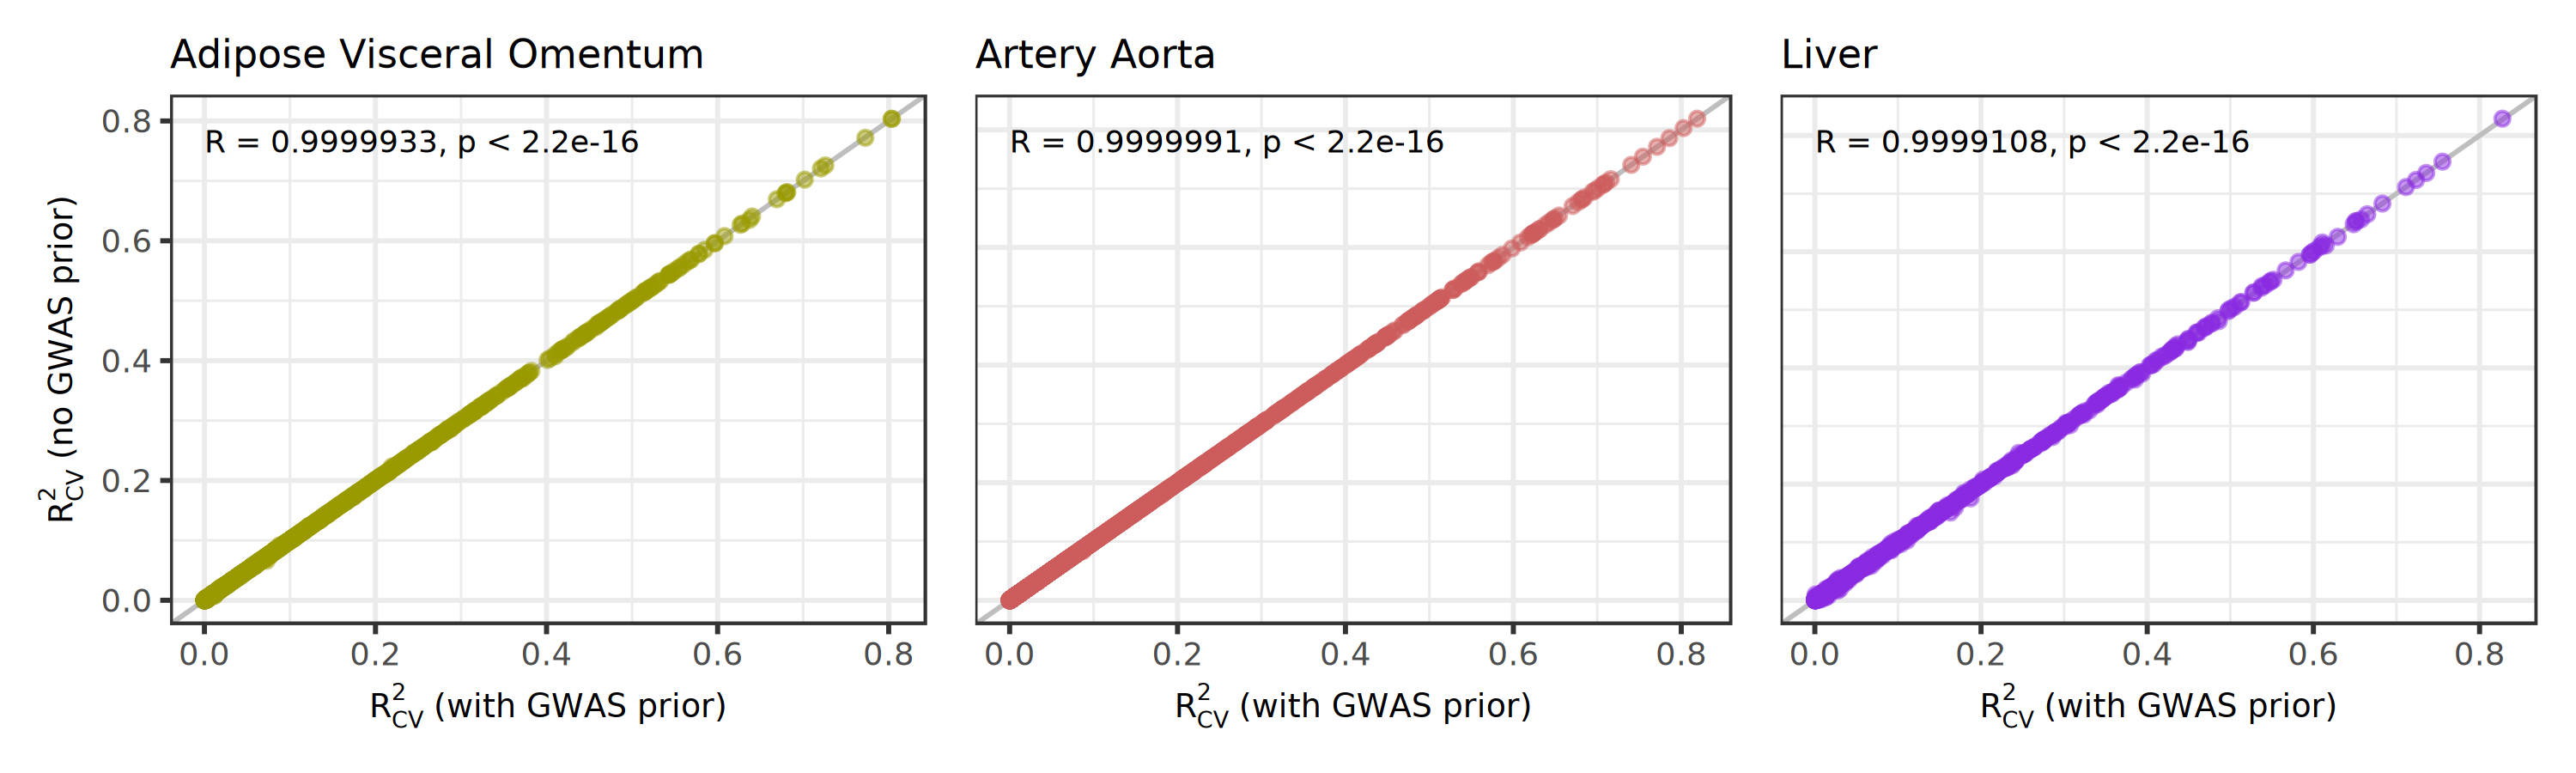

In [188]:
tr_cor

In [190]:
ggsave(paste0(results_dir, "nogwas_train_r2_scatter_cor.pdf"), tr_cor, width = 8, height = 3, dpi = 300)

In [191]:
n_ts_dx <- readr::read_tsv("/scratch/tmp/dolgalev/castom-igex-revision/OUTPUT_CAD/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2_nogwas/Meta_Analysis_CAD/tscore_pval_Dx_covCorr.txt", show_col_types = FALSE) %>% select(ensembl_gene_id, tissue, Dx_z)
g_ts_dx <- readr::read_tsv("/scratch/tmp/dolgalev/castom-igex-revision/OUTPUT_CAD/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/tscore_pval_Dx_covCorr.txt", show_col_types = FALSE) %>% select(ensembl_gene_id, tissue, Dx_z)

In [192]:
common_g <- do.call(paste, intersect(n_ts_dx[, 1:2], g_ts_dx[, 1:2])) 

In [193]:
g_ts_dx <- g_ts_dx[do.call(paste, g_ts_dx[, 1:2]) %in% common_g, ]
n_ts_dx <- n_ts_dx[do.call(paste, n_ts_dx[, 1:2]) %in% common_g, ]

In [194]:
g_ts_dx <- arrange(g_ts_dx, tissue, ensembl_gene_id)
n_ts_dx <- arrange(n_ts_dx, tissue, ensembl_gene_id)

ts_dx <- mutate(g_ts_dx, Dx_z_n = n_ts_dx$Dx_z)

In [195]:
ngw_t_z <- ggplot(ts_dx, aes(x = Dx_z, y = Dx_z_n, color = tissue)) +
  geom_abline(intercept = 0, slope = 1, color = "gray") +
  geom_point(alpha = 0.5) +
  scale_color_manual(values = c(col_plot_avo$color[1], col_plot_aao$color[1], col_plot_liv$color[1])) + 
  facet_grid(~ tissue) +
  labs(x = "TWAS z-stat (with GWAS prior)", y = "TWAS z-stat (no GWAS prior)") +
  guides(color = "none") +
  theme_bw()

ggsave(paste0(results_dir, "nogwas_twas_z_scatter.pdf"), ngw_t_z, width = 8, height = 3, dpi = 300)

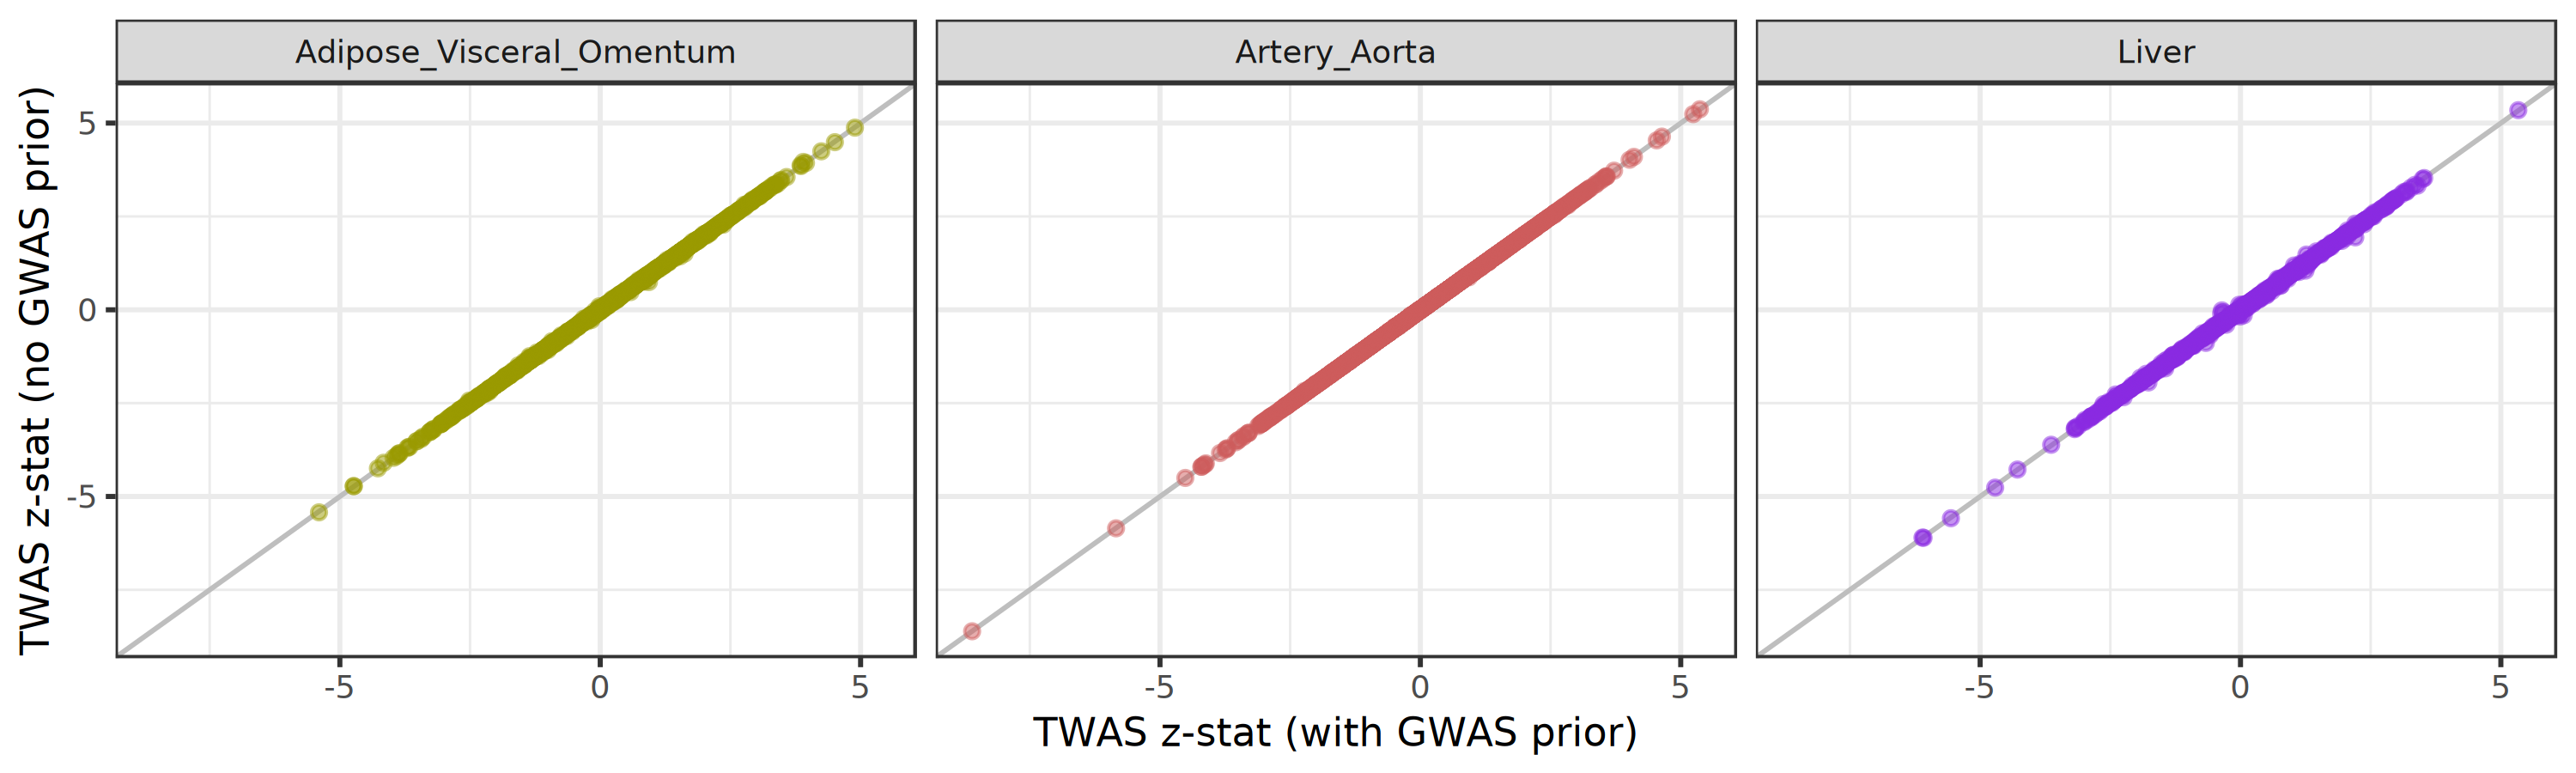

In [196]:
ngw_t_z

In [197]:
n_ps_dx <- readr::read_tsv("/scratch/tmp/dolgalev/castom-igex-revision/OUTPUT_CAD/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2_nogwas/Meta_Analysis_CAD/path_Reactome_pval_Dx_covCorr_filt.txt", show_col_types = FALSE) %>% select(path, tissue, Dx_z)
g_ps_dx <- readr::read_tsv("/scratch/tmp/dolgalev/castom-igex-revision/OUTPUT_CAD/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/path_Reactome_pval_Dx_covCorr_filt.txt", show_col_types = FALSE) %>% select(path, tissue, Dx_z)

In [198]:
colnames(n_ps_dx)

[1] "path"   "tissue" "Dx_z"

In [199]:
common_p <- do.call(paste, intersect(n_ps_dx[, 1:2], g_ps_dx[, 1:2])) 

In [200]:
g_ps_dx <- g_ps_dx[do.call(paste, g_ps_dx[, 1:2]) %in% common_p, ]
n_ps_dx <- n_ps_dx[do.call(paste, n_ps_dx[, 1:2]) %in% common_p, ]

In [201]:
g_ps_dx <- arrange(g_ps_dx, tissue, path)
n_ps_dx <- arrange(n_ps_dx, tissue, path)

ps_dx <- mutate(g_ps_dx, Dx_z_n = n_ps_dx$Dx_z, db = "Reactome")

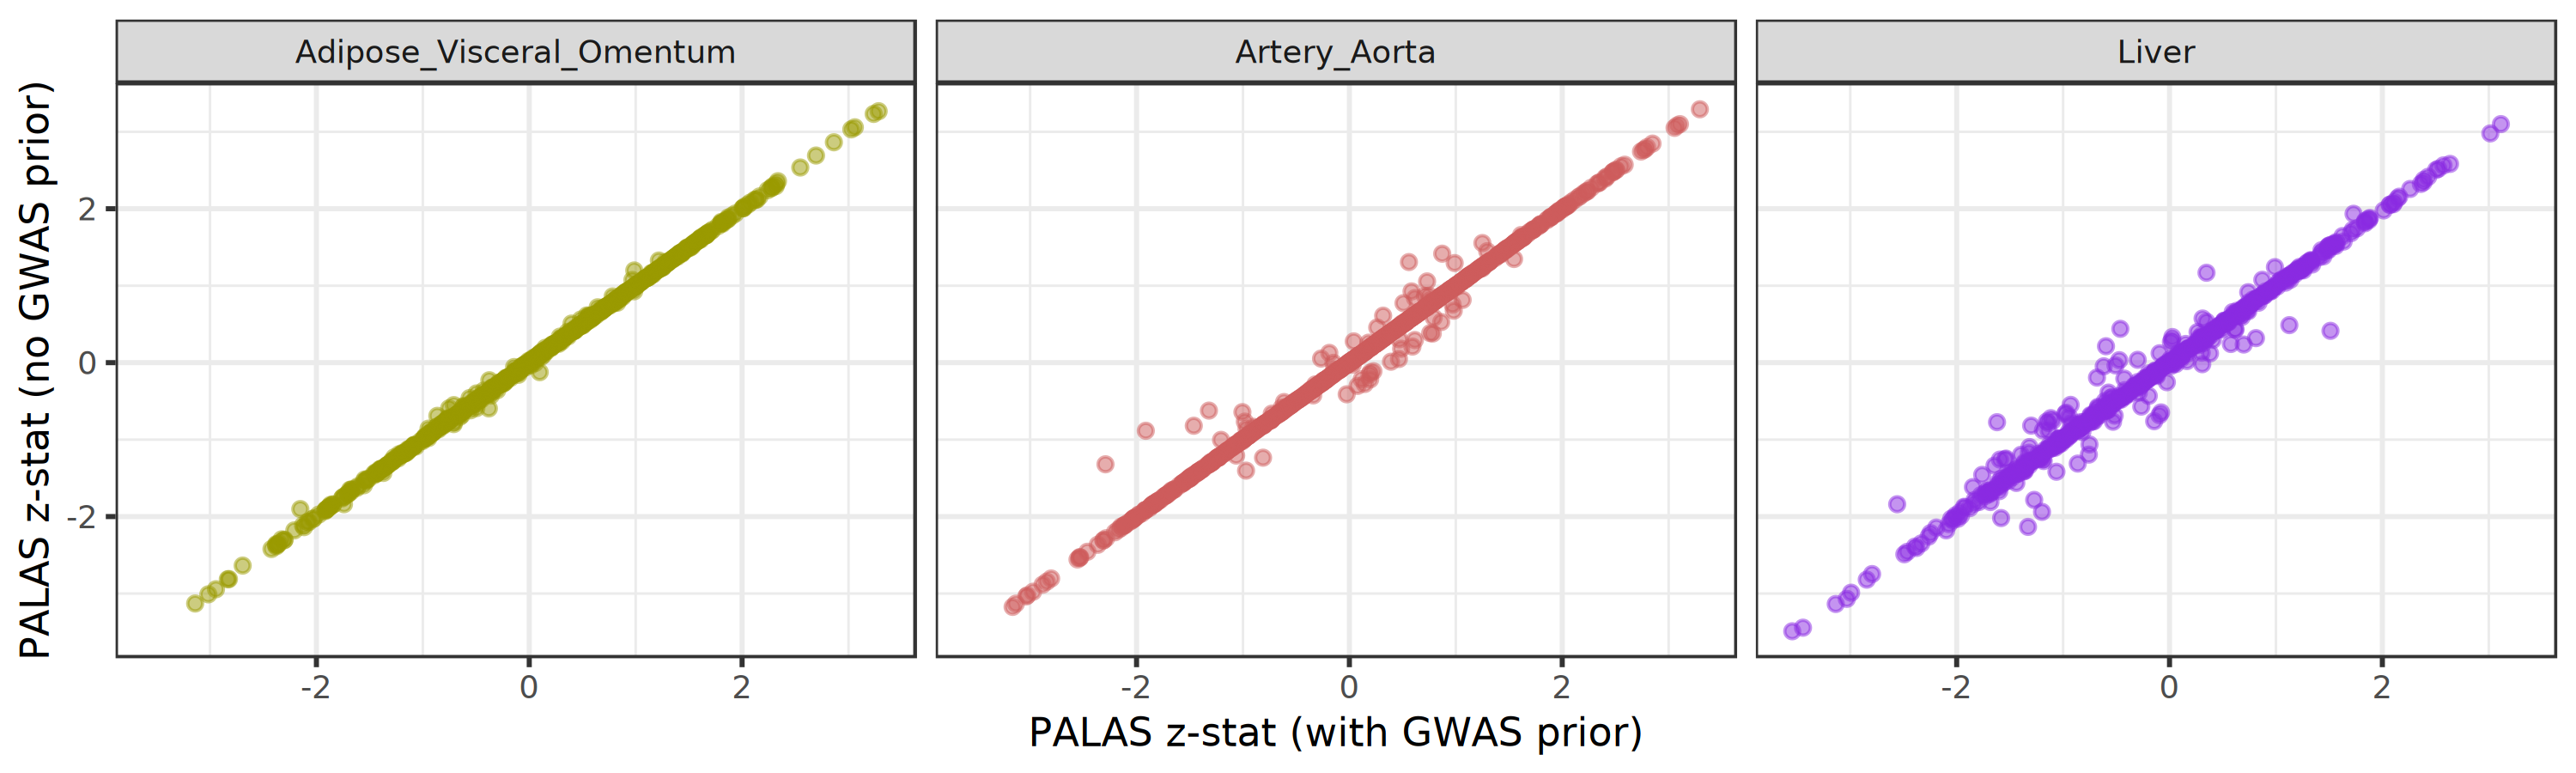

In [202]:
ggplot(ps_dx, aes(x = Dx_z, y = Dx_z_n, color = tissue)) +
  geom_point(alpha = 0.5) +
  scale_color_manual(values = c(col_plot_avo$color[1], col_plot_aao$color[1], col_plot_liv$color[1])) + 
  facet_grid(~ tissue) +
  labs(x = "PALAS z-stat (with GWAS prior)", y = "PALAS z-stat (no GWAS prior)") +
  guides(color = "none") +
  theme_bw()

In [203]:
n_gs_dx <- readr::read_tsv("/scratch/tmp/dolgalev/castom-igex-revision/OUTPUT_CAD/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2_nogwas/Meta_Analysis_CAD/path_GO_pval_Dx_covCorr_filt.txt", show_col_types = FALSE) %>% select(path, tissue, Dx_z)
g_gs_dx <- readr::read_tsv("/scratch/tmp/dolgalev/castom-igex-revision/OUTPUT_CAD/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/path_GO_pval_Dx_covCorr_filt.txt", show_col_types = FALSE) %>% select(path, tissue, Dx_z)

In [204]:
common_pg <- do.call(paste, intersect(n_gs_dx[, 1:2], g_gs_dx[, 1:2])) 

In [205]:
g_gs_dx <- g_gs_dx[do.call(paste, g_gs_dx[, 1:2]) %in% common_pg, ]
n_gs_dx <- n_gs_dx[do.call(paste, n_gs_dx[, 1:2]) %in% common_pg, ]

In [206]:
g_gs_dx <- arrange(g_gs_dx, tissue, path)
n_gs_dx <- arrange(n_gs_dx, tissue, path)

gs_dx <- mutate(g_gs_dx, Dx_z_n = n_gs_dx$Dx_z, db = "GO")

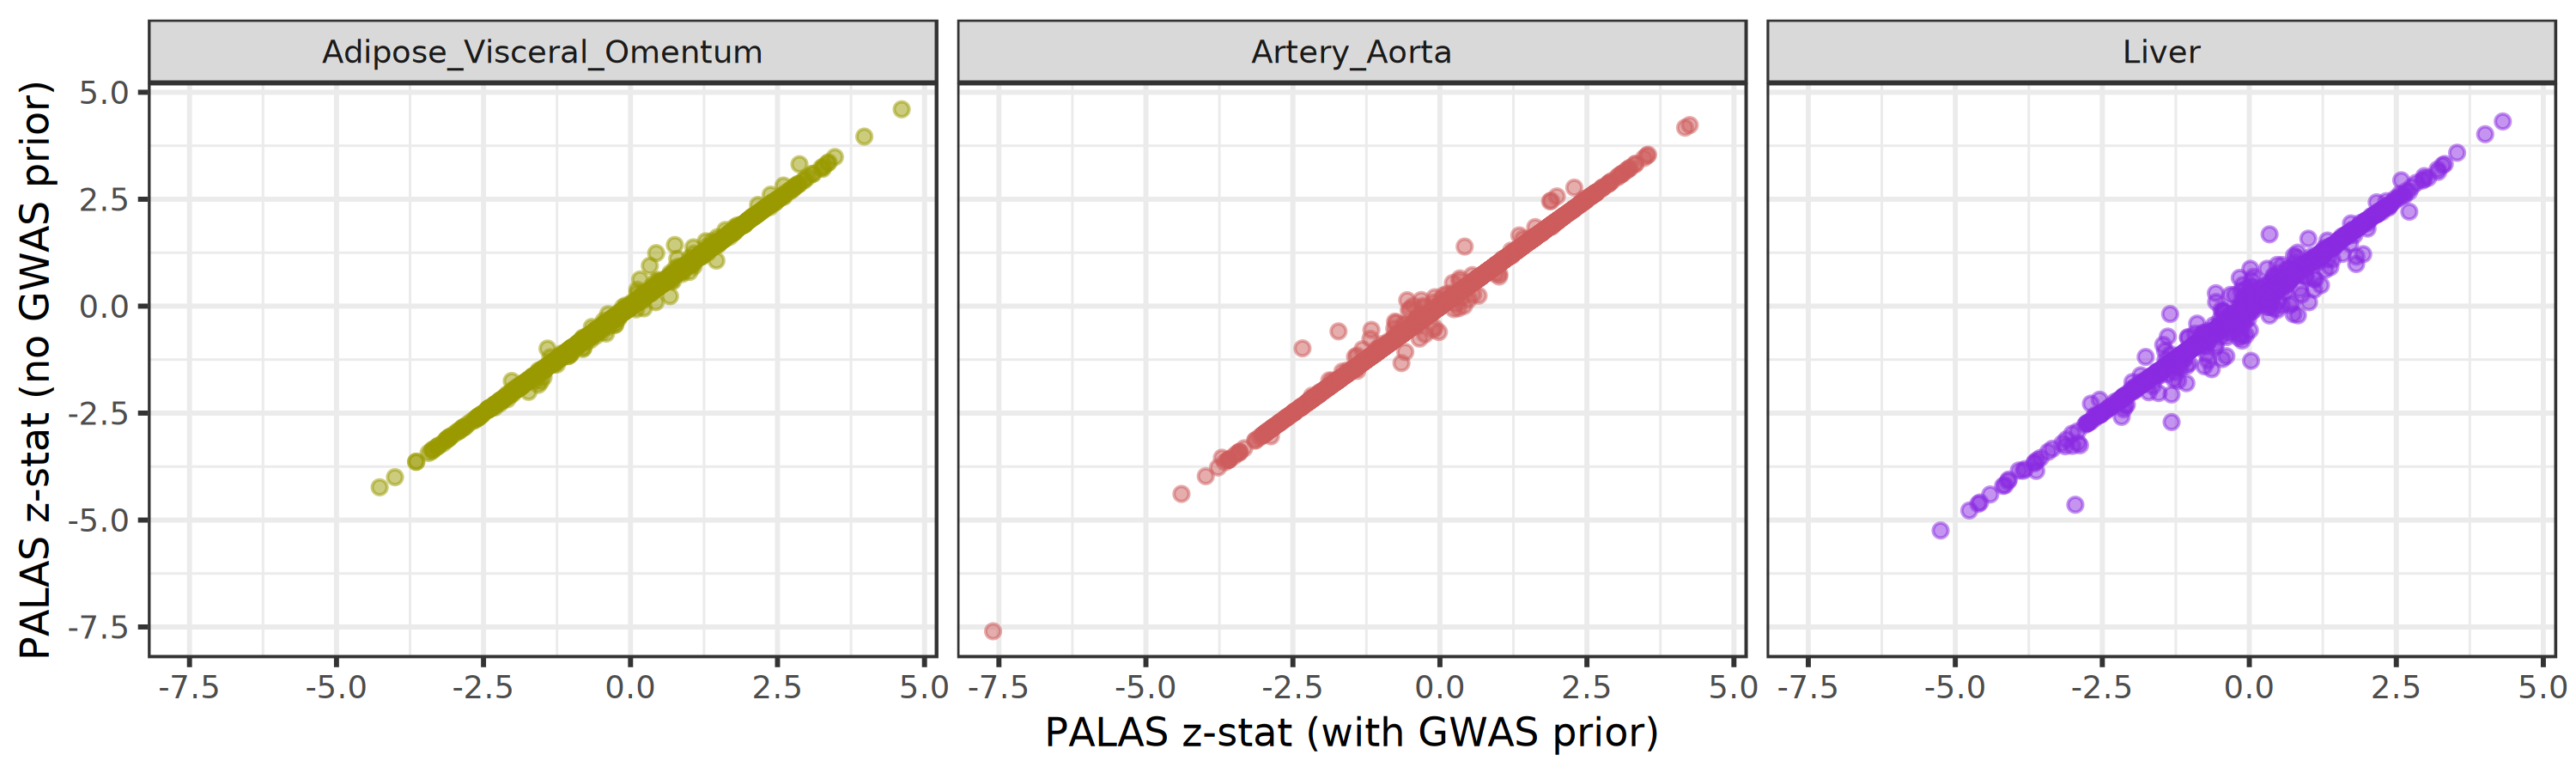

In [207]:
ggplot(gs_dx, aes(x = Dx_z, y = Dx_z_n, color = tissue)) +
  geom_point(alpha = 0.5) +
  scale_color_manual(values = c(col_plot_avo$color[1], col_plot_aao$color[1], col_plot_liv$color[1])) + 
  facet_grid(~ tissue) +
  labs(x = "PALAS z-stat (with GWAS prior)", y = "PALAS z-stat (no GWAS prior)") +
  guides(color = "none") +
  theme_bw()

In [208]:
n_ws_dx <- readr::read_tsv("/scratch/tmp/dolgalev/castom-igex-revision/OUTPUT_CAD/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2_nogwas/Meta_Analysis_CAD/path_WikiPath2019Human_pval_Dx_covCorr_filt.txt", show_col_types = FALSE) %>% select(path, tissue, Dx_z)
g_ws_dx <- readr::read_tsv("/scratch/tmp/dolgalev/castom-igex-revision/OUTPUT_CAD/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/path_WikiPath2019Human_pval_Dx_covCorr_filt.txt", show_col_types = FALSE) %>% select(path, tissue, Dx_z)

In [209]:
common_pw <- do.call(paste, intersect(n_ws_dx[, 1:2], g_ws_dx[, 1:2])) 

In [210]:
g_ws_dx <- g_ws_dx[do.call(paste, g_ws_dx[, 1:2]) %in% common_pw, ]
n_ws_dx <- n_ws_dx[do.call(paste, n_ws_dx[, 1:2]) %in% common_pw, ]

In [211]:
g_ws_dx <- arrange(g_ws_dx, tissue, path)
n_ws_dx <- arrange(n_ws_dx, tissue, path)

ws_dx <- mutate(g_ws_dx, Dx_z_n = n_ws_dx$Dx_z, db = "WikiPathways")

In [212]:
pdx <- rbind(ps_dx, gs_dx, ws_dx)

In [213]:
head(pdx)

path,tissue,Dx_z,Dx_z_n,db
<chr>,<chr>,<dbl>,<dbl>,<chr>
A tetrasaccharide linker sequence is required for GAG synthesis,Adipose_Visceral_Omentum,-0.30043397,-0.35789974,Reactome
ABC transporter disorders,Adipose_Visceral_Omentum,1.56098402,1.56326827,Reactome
ABC-family proteins mediated transport,Adipose_Visceral_Omentum,1.25989658,1.25516409,Reactome
ADP signalling through P2Y purinoceptor 12,Adipose_Visceral_Omentum,-0.98206135,-0.98050560,Reactome
APC/C:Cdc20 mediated degradation of Cyclin B,Adipose_Visceral_Omentum,1.93709931,1.93792840,Reactome
APEX1-Independent Resolution of AP Sites via the Single Nucleotide Replacement Pathway,Adipose_Visceral_Omentum,0.02215555,0.02957858,Reactome


In [214]:
options(repr.plot.width = 10)

ngw_palas_z <- ggplot(pdx, aes(x = Dx_z, y = Dx_z_n, color = tissue, shape = db)) +
  geom_abline(intercept = 0, slope = 1, color = "gray") +
  geom_point(alpha = 0.5) +
  scale_color_manual(values = c(col_plot_avo$color[1], col_plot_aao$color[1], col_plot_liv$color[1])) + 
  facet_grid(~ tissue) +
  labs(x = "PALAS z-stat (with GWAS prior)", y = "PALAS z-stat (no GWAS prior)", shape = "Database") +
  guides(color = "none") +
  theme_bw()

ggsave(paste0(results_dir, "nogwas_palas_z_scatter.pdf"), ngw_palas_z, width = 9, height = 3, dpi = 300)

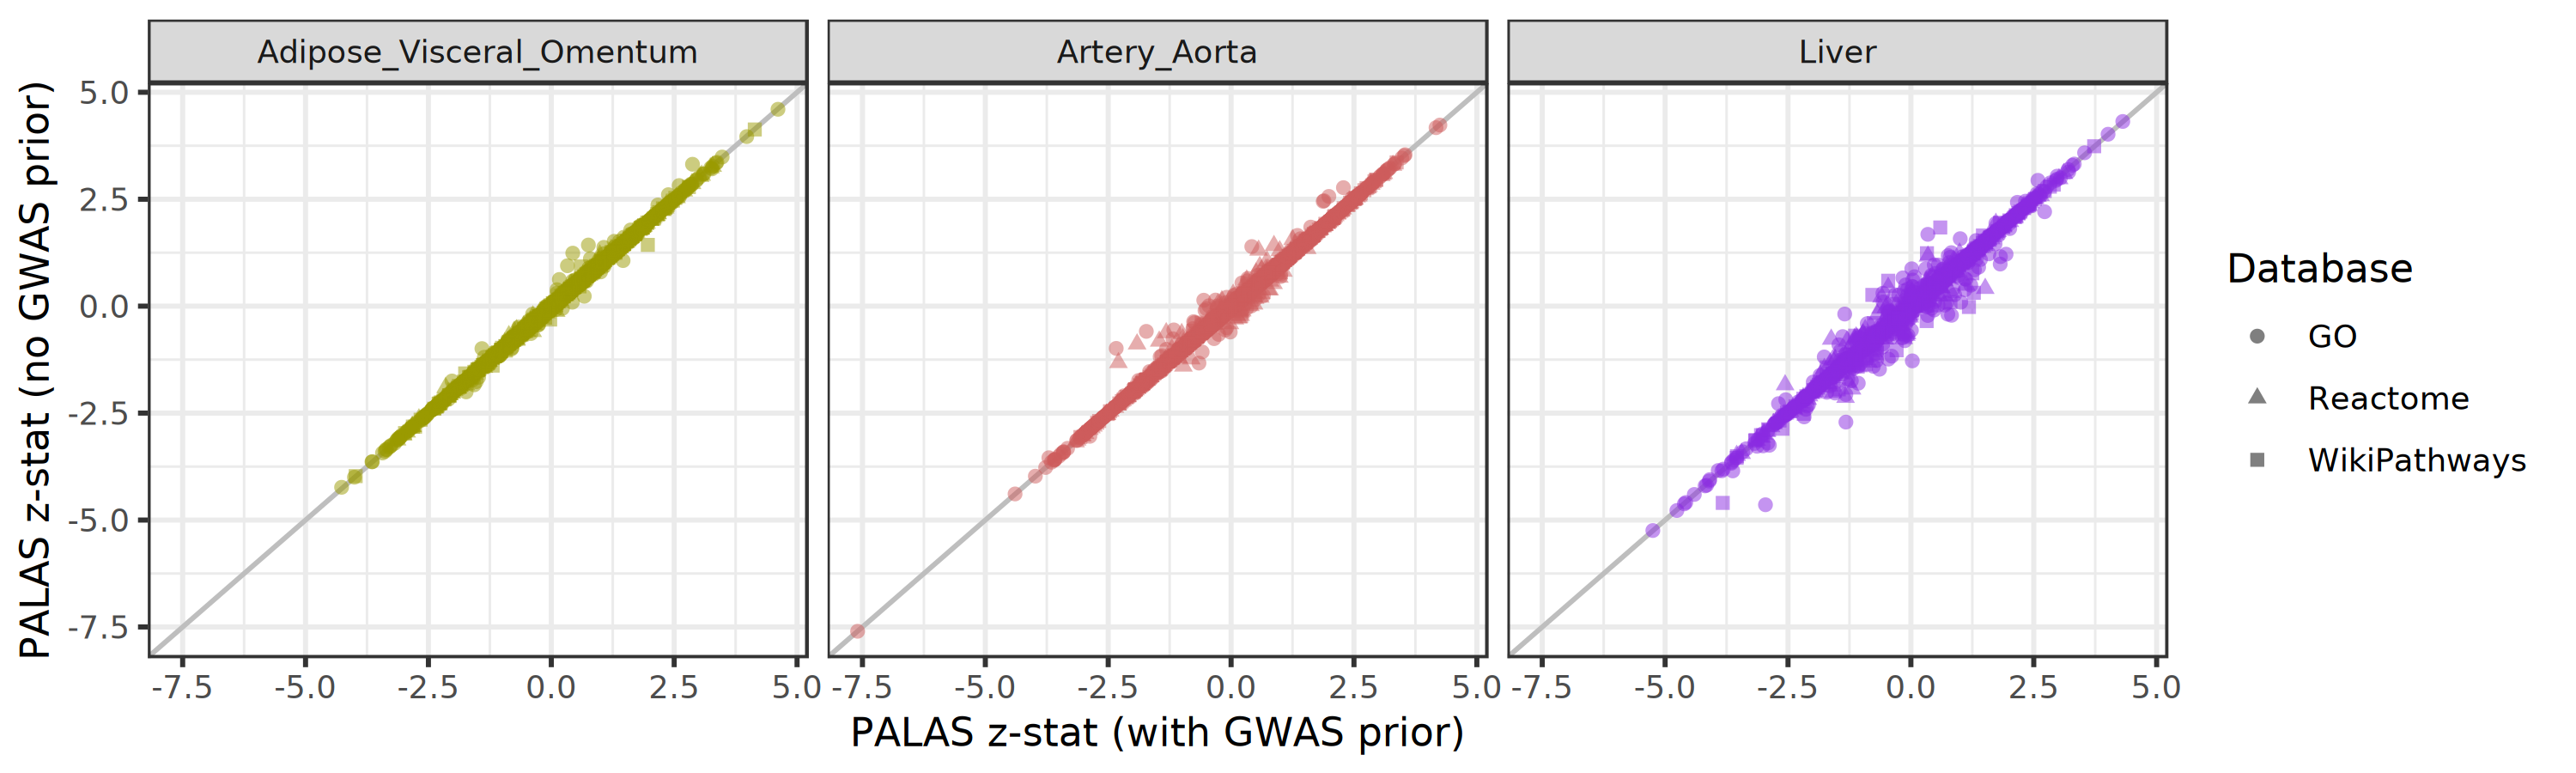

In [215]:
ngw_palas_z